## 1.abalone_benchmark

In [2]:
import os
import sys
import pandas as pd
import numpy as np
from scipy import stats
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.utility import standardizer
from pyod.models.lof import LOF
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from sklearn.model_selection import train_test_split
from pyod.utils.utility import precision_n_scores
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm


### 1.1 处理数据

In [3]:
def list_dir(file_dir):
    file_list=[]
    for f in os.listdir(file_dir):
        file_list.append(os.path.join(file_dir,f))
    return file_list

In [4]:
def process_data(file):
    df=pd.read_csv(file)
    x=df.drop(['ground.truth','point.id','motherset','origin','original.label'],axis = 1).values
    y=df['ground.truth'].values
    y=[0 if label=='nominal' else 1 for label in y]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=random_state)
    x_train, x_test = standardizer(x_train, x_test)
    return x_train,y_train,x_test,y_test

In [5]:
file_list=list_dir('./abalone/benchmarks')

### 1.2 模型
测试7个模型：
1. ABOD 
    - 考虑了每个数据点和其邻居的关系，但是不考虑邻居之间的关系。ABOD在多维度数据上表现较好。
2. CBLOF
    - 它将数据分为小聚类簇和大聚类簇。离群得分基于数据点所属的聚类簇的大小来计算，距离计算方式为到最近大聚类簇的距离。
3.  Feature Bagging
    - 一个特征集合检测器，它在数据集的一系列子集上拟合了大量的基准检测器。它使用平均或者其他结合方法来提高预测准确率
4. HBOS
    - 一种高效的无监督方法，它假设特征之间独立，然后通过构建直方图来计算离群得分
5. Isolation Forest
    - 内部使用sklearn，此方法中，使用一个集合的树来完成数据分区。孤立森林提供农一个离群得分来判定一个数据点在结构中有多孤立。其离群得分用来将它与正常观测数据区分开来。
6. KNN
    - 对于任意数据点，其到第k个邻居的距离可以作为其离群得分
7. Average KNN
    - 使用全部k个邻居的平均距离作为离群得分

In [6]:
# 设置 5%的离群点数据
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# 定义7个后续会使用的离群点检测模型
classifiers = {
    "Angle-based Outlier Detector(ABOD)" : ABOD(contamination=outliers_fraction),
    "Cluster-based Local Outiler Factor (CBLOF)": CBLOF(contamination = outliers_fraction,check_estimator=False,random_state = random_state),
    "Feature Bagging" : FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state = random_state),
    "Histogram-base Outlier Detection(HBOS)" : HBOS(contamination=outliers_fraction),
    "Isolation Forest" :IForest(contamination=outliers_fraction,random_state = random_state),
    "KNN" : KNN(contamination=outliers_fraction),
    "Average KNN" :KNN(method='mean',contamination=outliers_fraction)
}

将每个文件的数据分为训练集和测试集，分别记录7个模型的平均roc和prn

In [9]:
roc=[]
prn=[]
for i,(clf_name,clf) in enumerate(classifiers.items()):
    print("model:"+clf_name)
    cls_roc=[]
    cls_prn=[]
    
    for file in file_list:
         # Generate sample data
        X_train, y_train, X_test, y_test = process_data(file)
        
        try:
            clf.fit(X_train)
            y_test_pred = clf.predict(X_test)
            y_test_scores = clf.decision_function(X_test) 
            y_true = column_or_1d(y_test)
            y_pred = column_or_1d(y_test_scores)
            check_consistent_length(y_true, y_pred)
            cls_roc.append(np.round(roc_auc_score(y_true, y_pred), decimals=4))
            cls_prn.append(np.round(precision_n_scores(y_true, y_pred), decimals=4))
        except :
            continue
    roc.append(np.average(cls_roc))
    prn.append(np.average(cls_prn))
    print("average roc:{}".format(roc[-1]))
    print("average prn:{}".format(prn[-1]))

model:Angle-based Outlier Detector(ABOD)
average roc:0.7291886306532663
average prn:0.25781168341708544
model:Cluster-based Local Outiler Factor (CBLOF)
average roc:0.7100277468706537
average prn:0.2882796940194715
model:Feature Bagging
average roc:0.6996175641025641
average prn:0.2547246153846154
model:Histogram-base Outlier Detection(HBOS)


D:\ProgramData\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


average roc:0.6990394518801784
average prn:0.26661191841937537
model:Isolation Forest
average roc:0.687851835443038
average prn:0.27894664556962023
model:KNN
average roc:0.7389358942065491
average prn:0.2999775188916876
model:Average KNN
average roc:0.7370792775665398
average prn:0.2980160329531052


### 1.3 结果分析
比较不同模型的平均roc与prn

ABOB
0.7291886306532663
CBLOF
0.7100277468706537
FB
0.6996175641025641
HBOD
0.6990394518801784
IForest
0.687851835443038
KNN
0.7389358942065491
Mean KNN
0.7370792775665398


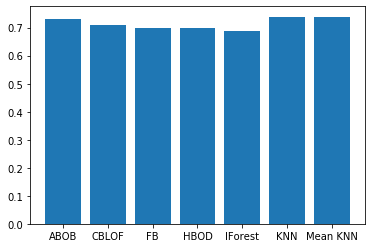

In [13]:
name=['ABOB','CBLOF','FB','HBOD','IForest','KNN','Mean KNN']
# 可视化roc
for i in range(len(name)):
    print(name[i])
    print(roc[i])
    
plt.bar(range(len(roc)), roc, tick_label=name)
plt.show()

由上图可知，七个模型的平均roc值都在0.7左右，其中KNN和Mean KNN的roc最高，均超过了0.73，说明knn在离群点分析方面效果更好一些

ABOB
0.25781168341708544
CBLOF
0.2882796940194715
FB
0.2547246153846154
HBOD
0.26661191841937537
IForest
0.27894664556962023
KNN
0.2999775188916876
Mean KNN
0.2980160329531052


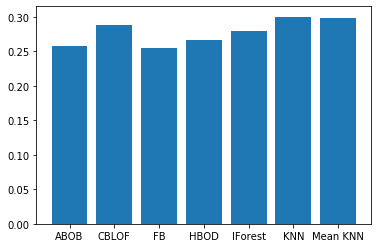

In [14]:
# prn
for i in range(len(name)):
    print(name[i])
    print(prn[i])
plt.bar(range(len(prn)), prn, tick_label=name)
plt.show()

prn指模型前n个的准确率，可以看到，七个模型整体的prn都不是很高，Feature Bagging结果最低，两种KNN算法的prn值最高，接近0.3，这和roc有同样的趋势。

## 2.skin_benchmark
加载数据与模型的方法与abalone一致，X只取R、G、B三个属性值

In [7]:
file_list=list_dir('./skin/benchmarks')


In [7]:
roc=[]
prn=[]
for i,(clf_name,clf) in enumerate(classifiers.items()):
    break
    print("model:"+clf_name)
    cls_roc=[]
    cls_prn=[]
    for file in file_list:
         # Generate sample data
        df=pd.read_csv(file)
        data.loc[data['ground.truth'] == 'anomaly','ground.truth'] = 1
        data.loc[data['ground.truth'] == 'nominal','ground.truth'] = 0
    
        X = data[["R","G","B"]].values
        Y = data['ground.truth'].values.tolist()
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

        
        # 训练模型
        try:
            clf.fit(X_train)
            y_test_pred = clf.predict(X_test)
            y_test_scores = clf.decision_function(X_test) 
            y_true = column_or_1d(y_test)
            y_pred = column_or_1d(y_test_scores)
            check_consistent_length(y_true, y_pred)
            cls_roc.append(np.round(roc_auc_score(y_true, y_pred), decimals=4))
            cls_prn.append(np.round(precision_n_scores(y_true, y_pred), decimals=4))
            break
        except :
            continue
    roc.append(np.average(cls_roc))
    prn.append(np.average(cls_prn))
    print("average roc:{}".format(roc[-1]))
    print("average prn:{}".format(prn[-1]))

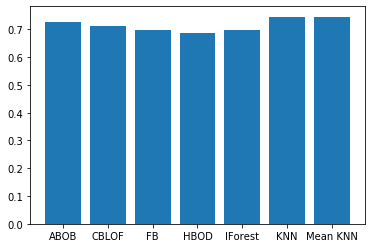

In [9]:
name=['ABOB','CBLOF','FB','HBOD','IForest','KNN','Mean KNN']
# 可视化roc
plt.bar(range(len(roc)), roc, tick_label=name)
plt.show()

可以看到，该数据集上的结果与上个数据集比较相似，模型都在0.70左右，KNN效果最好

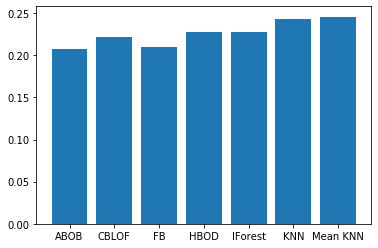

In [11]:
# prn
plt.bar(range(len(prn)), prn, tick_label=name)
plt.show()

由上图可知，KNN的pron值最好，Feature boosting比较差，这一部分和之前的结果相一致。